In [2]:
# --- 1. 라이브러리 임포트 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
!pip install keras-tuner -q # KerasTuner 설치
import keras_tuner as kt

# --- 2. 스타일 설정 ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- 3. 데이터 로드 ---
try:
    df = pd.read_csv('./gold_price_data.csv', parse_dates=['Date'], index_col='Date')
    print("데이터셋 로드 성공")
    print(f"데이터 형태: {df.shape}")
except FileNotFoundError:
    print("ERROR: 'gold_price_data.csv' 파일을 찾을 수 없습니다.")
    print("Colab 왼쪽에 있는 파일 탐색기 탭을 이용하여 파일을 업로드해주세요.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00
데이터셋 로드 성공!
데이터 형태: (10787, 1)


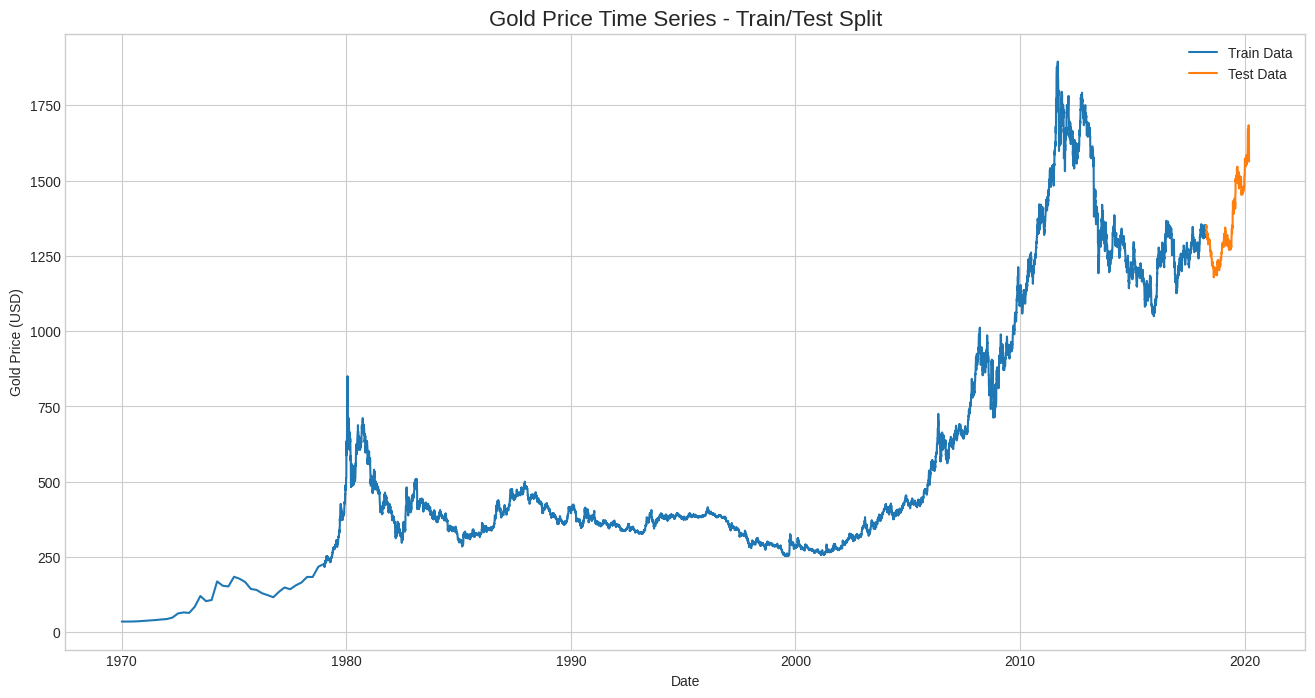

In [ ]:
# --- 분석 환경 설정 ---
CONFIG = {
    "prediction_days": 500, # 테스트할 기간 (일)
    "look_back": 30,        # 과거 30일 데이터를 보고 다음 날을 예측
    "tuner_max_trials": 10, # KerasTuner 최대 시도 횟수
    "final_epochs": 150     # 최종 모델 학습 에포크
}

# --- 데이터 분할 ---
train_df = df[:-CONFIG["prediction_days"]]
test_df = df[-CONFIG["prediction_days"]:]

# --- 데이터 분할 시각화 ---
plt.figure(figsize=(16, 8))
plt.title('Gold Price Time Series - Train/Test Split', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.plot(train_df['Value'], label='Train Data')
plt.plot(test_df['Value'], label='Test Data')
plt.legend()
plt.show()

In [4]:
# --- 1. 데이터 스케일링 (올바른 방법) ---
# 훈련 데이터의 분포를 기준으로 스케일러를 학습시킵니다.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df)

# 학습된 스케일러로 테스트 데이터를 변환합니다. (절대 fit_transform 사용 금지)
scaled_test = scaler.transform(test_df)

# --- 2. 시계열 데이터셋 생성 함수 ---
def create_dataset(dataset, look_back=30):
    """LSTM 모델 입력을 위한 시계열 데이터셋을 생성합니다."""
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# --- 3. 훈련 및 테스트 데이터셋 생성 ---
trainX, trainY = create_dataset(scaled_train, CONFIG['look_back'])
testX, testY = create_dataset(scaled_test, CONFIG['look_back'])

# --- 4. LSTM 입력 형태로 Reshape ---
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print("전처리 후 데이터 형태:")
print(f"trainX: {trainX.shape}, trainY: {trainY.shape}")
print(f"testX: {testX.shape}, testY: {testY.shape}")

전처리 후 데이터 형태:
trainX: (10257, 30, 1), trainY: (10257,)
testX: (470, 30, 1), testY: (470,)


In [5]:
# --- 1. 모델 빌더 함수 정의 ---
def model_builder(hp):
    """KerasTuner를 위한 모델 생성 함수."""
    model = Sequential()

    # 입력 LSTM 레이어의 유닛 수를 32에서 256 사이에서 탐색
    model.add(LSTM(
        units=hp.Int('units_input', min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(CONFIG['look_back'], 1)
    ))

    # 1개에서 3개 사이의 추가 LSTM 레이어 탐색
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            return_sequences=(i != hp.get('n_layers') - 1) # 마지막 레이어는 False
        ))

    # Dropout 비율을 0.1에서 0.5 사이에서 탐색
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1)) # 출력 레이어

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# --- 2. 튜너 설정 및 탐색 실행 ---
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=CONFIG['tuner_max_trials'],
    executions_per_trial=1,
    directory='gold_price_tuner',
    project_name='lstm_tuning'
)

# 조기 종료 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("--- 하이퍼파라미터 탐색 시작 ---")
tuner.search(trainX, trainY, epochs=50, validation_data=(testX, testY), callbacks=[early_stopping])

# --- 3. 최적 하이퍼파라미터 확인 ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- 최적 하이퍼파라미터 ---")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# 최적 모델 가져오기
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 01m 19s]
val_loss: 3.726546492544003e-05

Best val_loss So Far: 3.726546492544003e-05
Total elapsed time: 00h 07m 44s

--- 최적 하이퍼파라미터 ---
units_input: 64
n_layers: 1
units_0: 256
dropout_rate: 0.30000000000000004
units_1: 64


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- 최종 모델 학습 시작 ---
Epoch 1/150
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.7050e-04 - val_loss: 8.5381e-05
Epoch 2/150
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.7255e-04 - val_loss: 3.6389e-05
Epoch 3/150
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.6440e-04 - val_loss: 1.1021e-04
Epoch 4/150
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.6720e-04 - val_loss: 3.7010e-05
Epoch 5/150
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.6747e-04 - val_loss: 6.5088e-05
Epoch 6/150
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6030e-04 - val_loss: 7.0421e-04
Epoch 7/150
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.8305e-04 - val_loss: 3.6831e-05


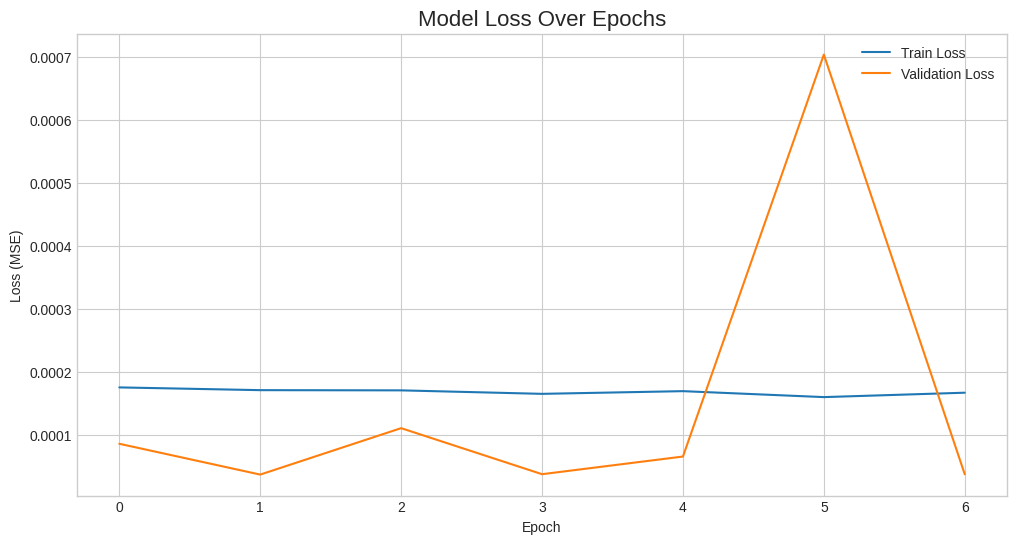

In [6]:
# --- 1. 최적 모델로 최종 학습 진행 ---
print("\n--- 최종 모델 학습 시작 ---")
history = best_model.fit(
    trainX, trainY,
    epochs=CONFIG['final_epochs'],
    validation_data=(testX, testY),
    callbacks=[early_stopping], # 조기 종료 적용
    verbose=1
)

# --- 2. 학습 과정(손실) 시각화 ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [7]:
# --- 1. 테스트 데이터에 대한 예측 ---
predicted_scaled = best_model.predict(testX)

# --- 2. 예측값을 원래 스케일로 복원 ---
predicted_price = scaler.inverse_transform(predicted_scaled)
true_price = scaler.inverse_transform(testY.reshape(-1, 1))

# --- 3. 정량적 성능 평가 ---
rmse = sqrt(mean_squared_error(true_price, predicted_price))
mae = mean_absolute_error(true_price, predicted_price)

print("-" * 30)
print("최종 모델 성능 평가:")
print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
print(f"MAE (Mean Absolute Error):    ${mae:.2f}")
print("-" * 30)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
------------------------------
최종 모델 성능 평가:
RMSE (Root Mean Squared Error): $11.29
MAE (Mean Absolute Error):    $7.93
------------------------------


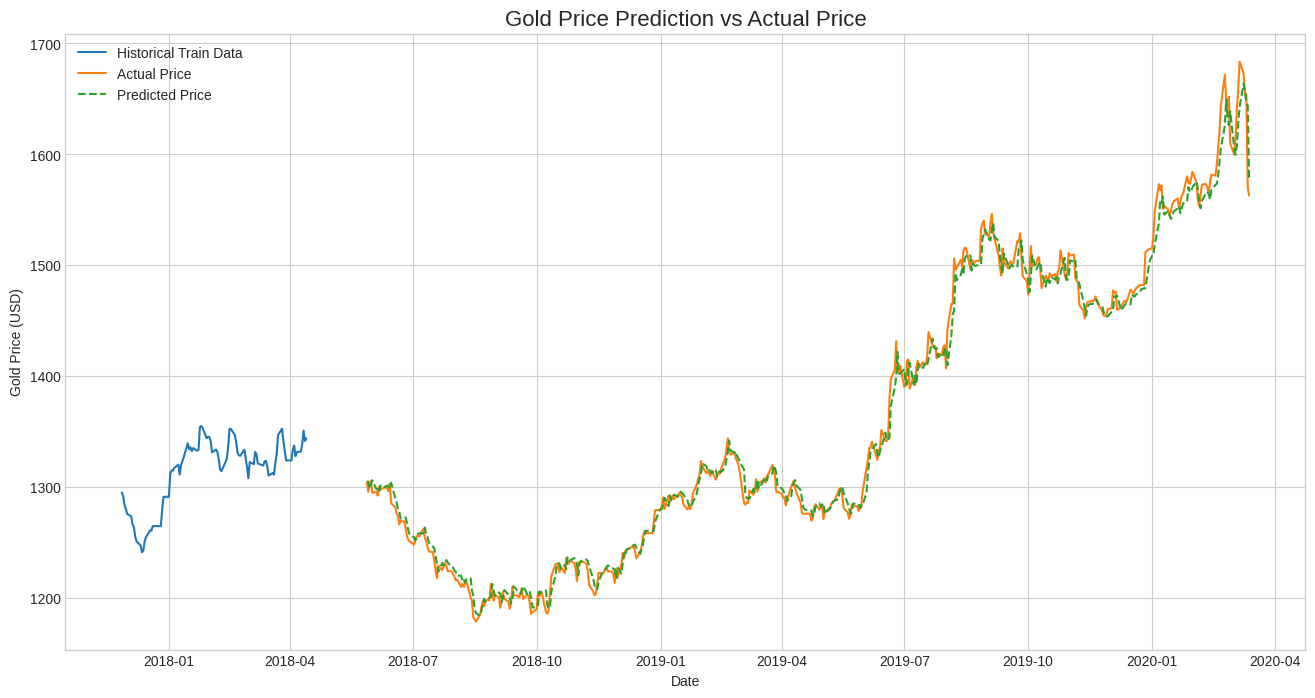

In [8]:
# --- 4. 예측 결과 시각화 ---
# 시각화를 위해 예측값과 실제값을 DataFrame으로 만듭니다.
test_dates = test_df.index[CONFIG['look_back']:]
prediction_df = pd.DataFrame({
    'Actual Price': true_price.flatten(),
    'Predicted Price': predicted_price.flatten()
}, index=test_dates)

plt.figure(figsize=(16, 8))
plt.title('Gold Price Prediction vs Actual Price', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')

# 시각적 비교를 위해 훈련 데이터의 끝부분도 함께 표시
plt.plot(train_df['Value'][-100:], label='Historical Train Data')
plt.plot(prediction_df['Actual Price'], label='Actual Price')
plt.plot(prediction_df['Predicted Price'], label='Predicted Price', linestyle='--')

plt.legend()
plt.show()